In [1]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("whitegrid")
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

import random
#from pyswarm import pso
import isocor

In [2]:
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
palette = sns.color_palette(as_cmap=True)

In [4]:
element_prob_dict = {
    'N_natural': 0.00364,
    'N_enriched': 0.997774,
    'C_natural': 0.0107,
    'C_enriched': 0.99999
}

In [5]:
AA_keys = ['Alanine pos', 'Arginine pos', 'Asparagine pos', 'Aspartate neg', 'Cystine pos', 'Glutamate neg', 'Glutamine pos', 'Glycine neg', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Methionine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Tryptophan pos', 'Tyrosine pos', 'Valine pos']


GAUCT_keys = ['Guanine pos', 'Adenine pos', 'Uracil neg', 'Cytosine pos', 'Thymine neg', 'Hypoxanthine pos']
pool14_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Deoxyuridine neg', 'Cytidine pos', 'Guanosine pos', 'Uridine neg']
nucl_breakdown_keys = GAUCT_keys + ['Uric acid neg', 'Xanthine neg']

In [6]:
annotation_df = pd.read_excel('annotations.xlsx')

# Normalize to U-15N, U13-C amino acid internal standards

In [7]:
### Read measurements

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide-digest_acid-hydrolysis_09_18-dec_06-jan.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned on
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and True:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2] + '_' + fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)


df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [7]:
### Show depletion of amino acids during acid hydrolysis ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Amino acid mix')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

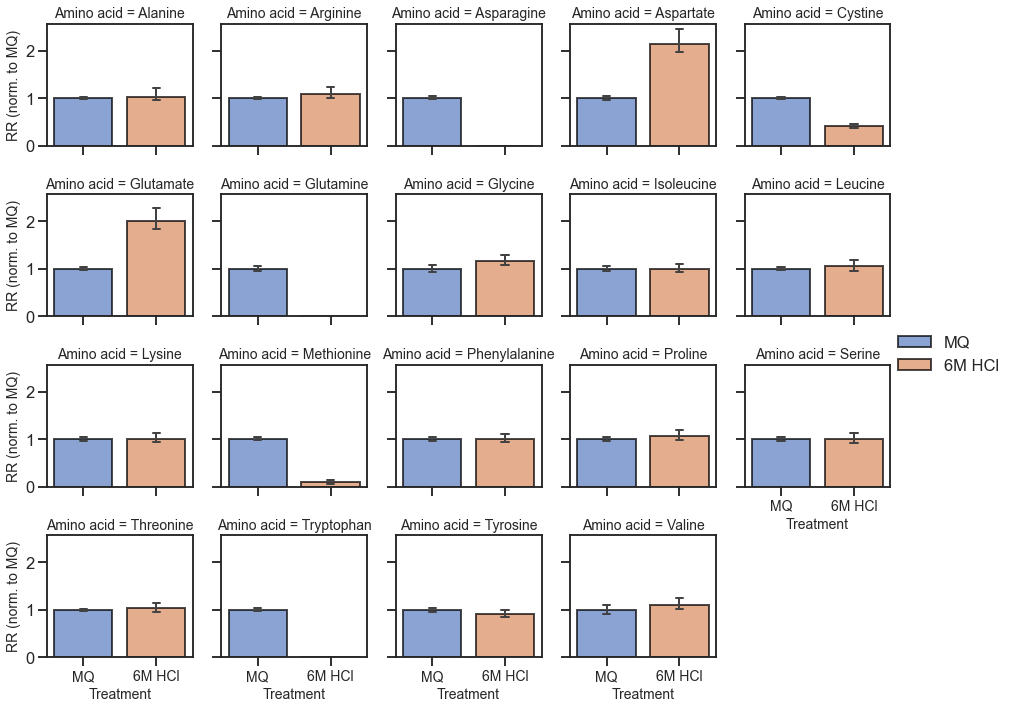

In [15]:
plot_name = 'AA_acid-hydrolysis-stability.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=99, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [16]:
### Show appearance of amino acids after acid incubation of GAUCT ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'GAUCT')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

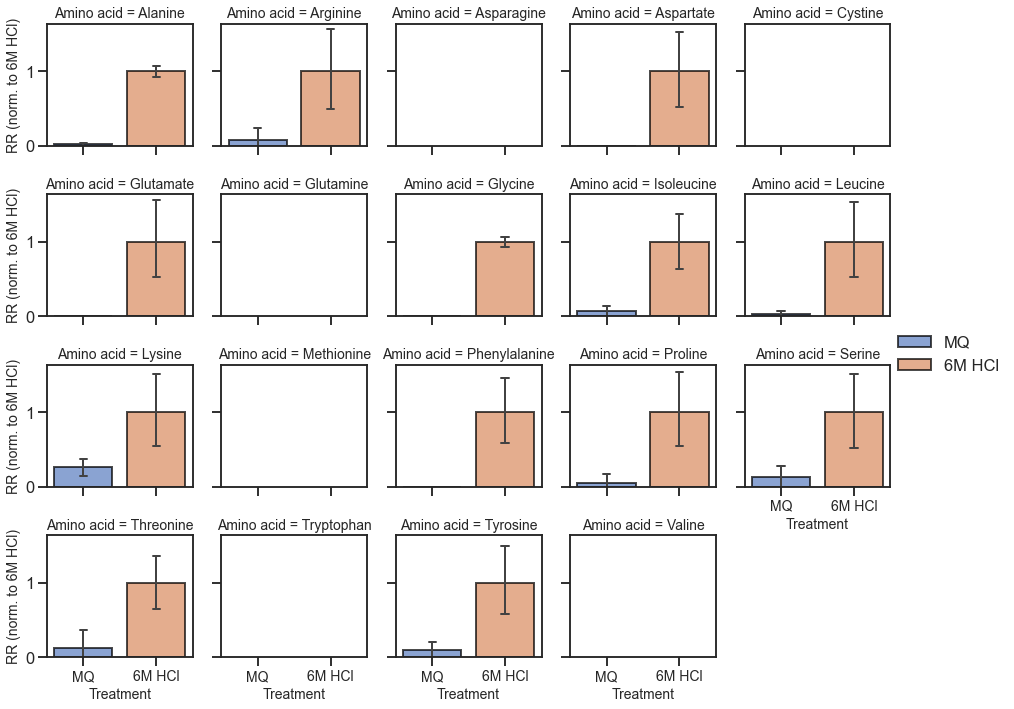

In [18]:
plot_name = 'GAUCT-HCl-amino-acid-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to 6M HCl)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [19]:
### Show appearance of amino acids after acid incubation of GAUCT ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'GAUCT')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

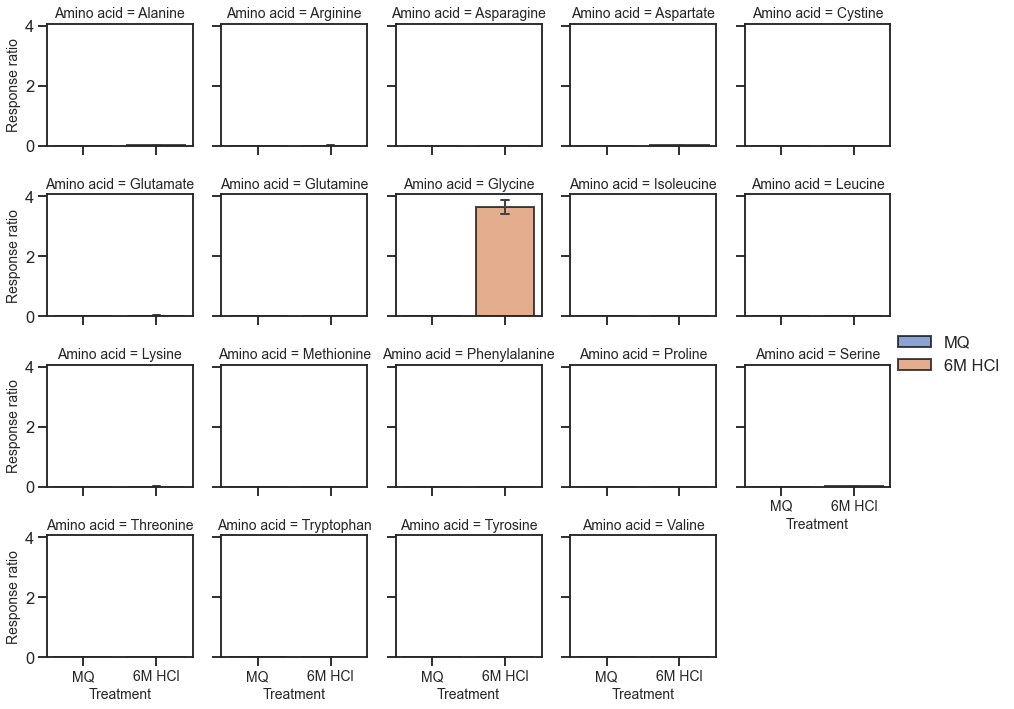

In [20]:
plot_name = 'GAUCT-HCl-amino-acid-release_no-norm.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show();
pdf_plot.close()

In [21]:
### Show appearance of amino acids after acid incubation of GAUCT ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'GAUCT')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    if metab == 'Glycine neg':
        continue
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

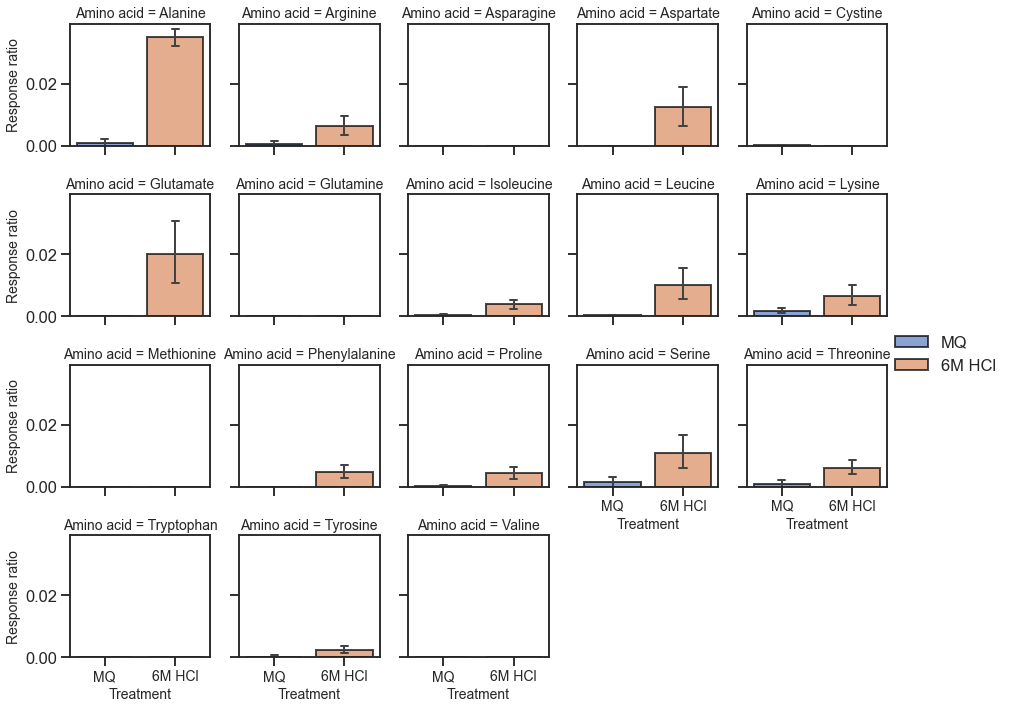

In [22]:
plot_name = 'GAUCT-HCl-amino-acid-release_no-norm_no-gly.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [23]:
### Show decrease in certain nucleobases after acid treatment of GAUCT ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'GAUCT')
df_nuc = df[mask]

metab_mask = ['Buffer'] + nucl_breakdown_keys
df_metab = df_nuc.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in nucl_breakdown_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

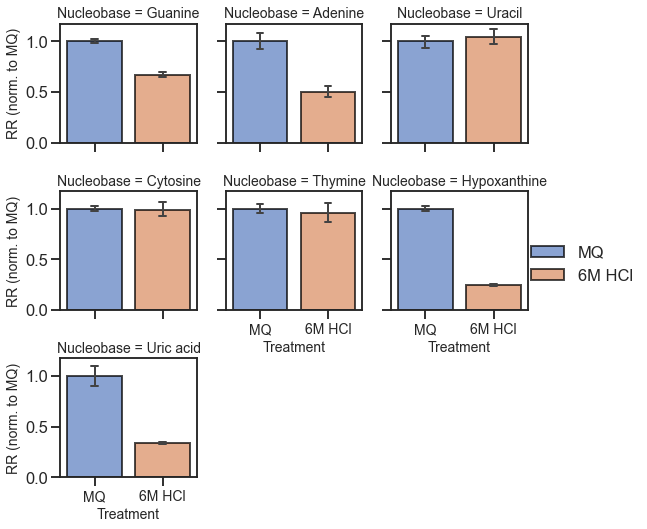

In [24]:
plot_name = 'GAUCT-HCl-nucleobase-degradation.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

mask = df_metab_flat['Nucleobase'] != 'Xanthine'
sns_fig = sns.FacetGrid(df_metab_flat[mask], col='Nucleobase', height=2.5, col_wrap=3, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

<Figure size 432x288 with 0 Axes>

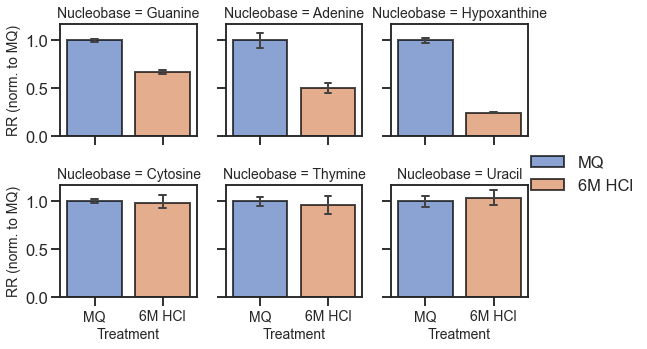

In [31]:
plot_name = 'purine-degradation.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

mask = (df_metab_flat['Nucleobase'] != 'Xanthine') & (df_metab_flat['Nucleobase'] != 'Uric acid')
col_order = ['Guanine', 'Adenine', 'Hypoxanthine', 'Cytosine', 'Thymine', 'Uracil']
sns_fig = sns.FacetGrid(df_metab_flat[mask], col='Nucleobase', height=2.5, col_wrap=3, despine=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

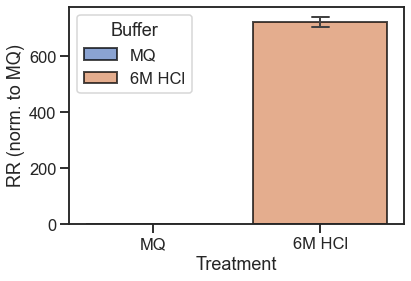

In [25]:
plot_name = 'GAUCT-HCl-nucleobase-degradation_Xanthine.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()


sns_fig = sns.barplot(x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette, data=df_metab_flat[~mask])

sns_fig.set_xlabel('Treatment')
sns_fig.set_ylabel('RR (norm. to MQ)')


pdf_plot.savefig(sns_fig.figure, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [32]:
### Show appearance of amino acids after acid incubation of Pool 14 ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Pool 14')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

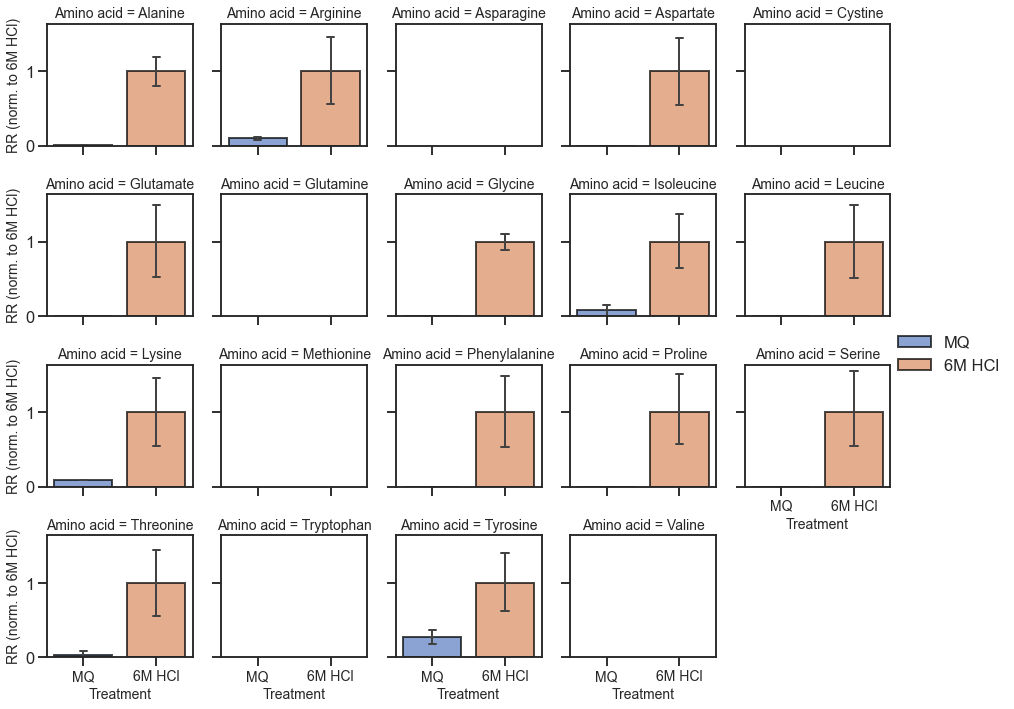

In [33]:
plot_name = 'Pool-14-HCl-amino-acid-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to 6M HCl)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [34]:
### Show appearance of amino acids after acid incubation of Pool 14 ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Pool 14')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

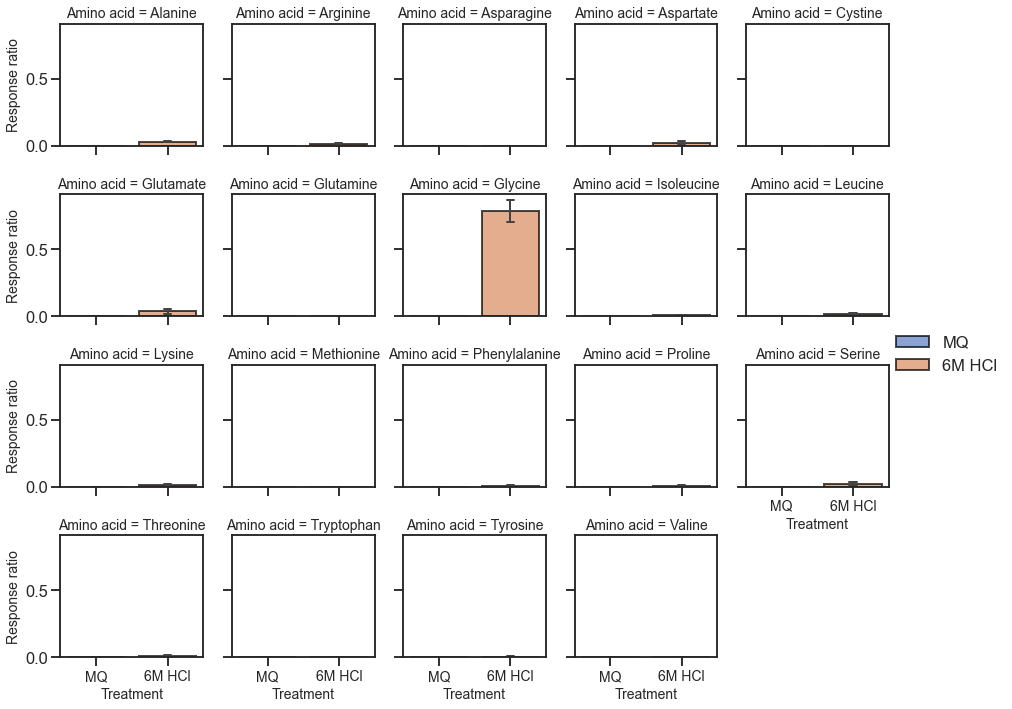

In [37]:
plot_name = 'Pool-14-HCl-amino-acid-release_no-norm.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [38]:
### Show appearance of amino acids after acid incubation of Pool 14 ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Pool 14')
df_AA = df[mask]

metab_mask = ['Buffer'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in AA_keys:
    if metab == 'Glycine neg':
        continue
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

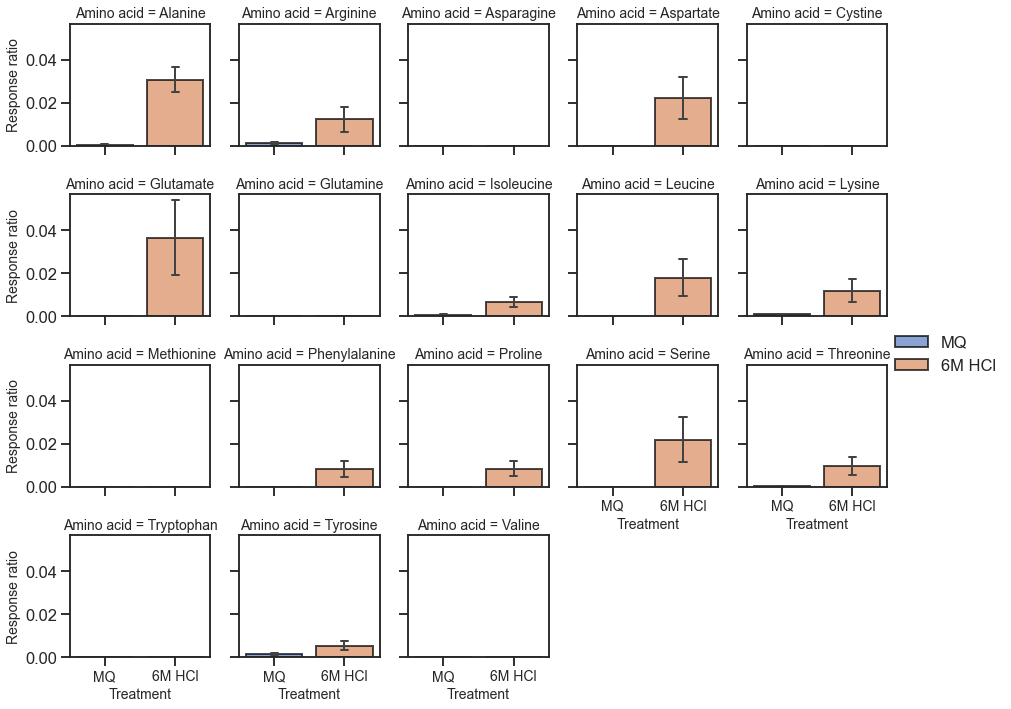

In [39]:
plot_name = 'Pool-14-HCl-amino-acid-release_no-norm_no-gly.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [40]:
### Show decrease in certain nucleosides after acid treatment of Pool 14 ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Pool 14')
df_nuc = df[mask]

metab_mask = ['Buffer'] + pool14_keys
df_metab = df_nuc.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in pool14_keys:
    mask_MQ = df_metab['Buffer'] == 'MQ'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleosides', 'value': 'Peak area'})

In [1]:
plot_name = 'Pool-14-HCl-nucleobase-degradation.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

#mask = df_metab_flat['Nucleobase'] != 'Xanthine'
col_order = ['Uridine', 'Deoxyuridine', 'Deoxythymidine', 'Cytidine', 'Deoxycytidine', 'Adenosine', 'Guanosine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleosides', height=2.5, col_wrap=3, despine=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to MQ)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=12)
sns_fig.add_legend()



pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

NameError: name 'matplotlib' is not defined

In [44]:
### Show increase in certain nucleobases after acid treatment of Pool 14 ###
mask = (df['Exp. name'] == 'Acid stability') & (df['Content'] == 'Pool 14')
df_nuc = df[mask]

metab_mask = ['Buffer'] + nucl_breakdown_keys
df_metab = df_nuc.loc[:, metab_mask]

metab_mask = ['Buffer']
for metab in nucl_breakdown_keys:
    mask_MQ = df_metab['Buffer'] == '6M HCl'
    metab_name = metab[0:-4]
    metab_MQ_mean = df_metab.loc[mask_MQ, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_MQ_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer']).rename(columns={'variable': 'Nucleobases', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

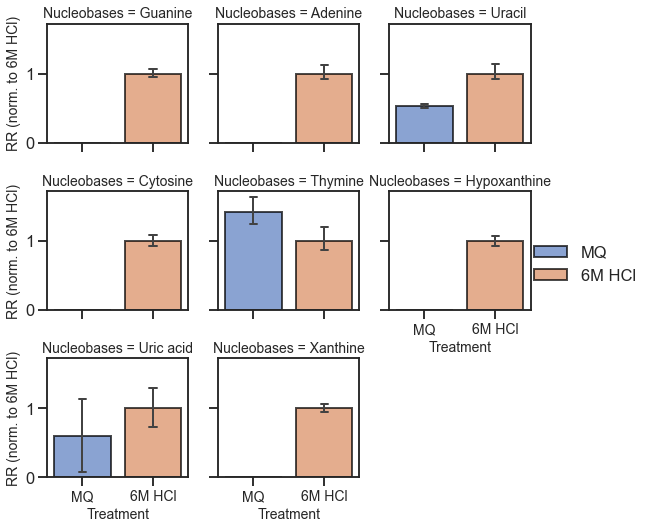

In [45]:
plot_name = 'Pool-14-HCl-nucleobase-degradation_nucleobases.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobases', height=2.5, col_wrap=3, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Buffer', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Treatment', 'RR (norm. to 6M HCl)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

# Raw peak area, no normalization 

In [29]:
### Read measurements

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide-digest_acid-hydrolysis_09_18-dec_06-jan.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned on
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and False:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2] + '_' + fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)


df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [30]:
### Show appearance of amino acids after acid incubation correlates between samples ###
mask = (df['Buffer'] == '6M HCl') & ( (df['Content'] == 'GAUCT') |  (df['Content'] == 'Pool 14') | (df['Content'] == 'DNA') )
df_AA = df[mask]

metab_mask = ['Content'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Content']
for metab in AA_keys:
    if metab == 'Glycine neg':
        continue
    metab_name = metab[0:-4]
    df_metab[metab_name] = df_metab[metab]
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

for idx in df_metab.index.values:
    mv = df_metab.loc[idx, metab_mask[1:]].values.max()
    df_metab.loc[idx, metab_mask[1:]] = df_metab.loc[idx, metab_mask[1:]] / mv

df_metab_flat = pd.melt(df_metab, id_vars=['Content']).rename(columns={'variable': 'Amino acid', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

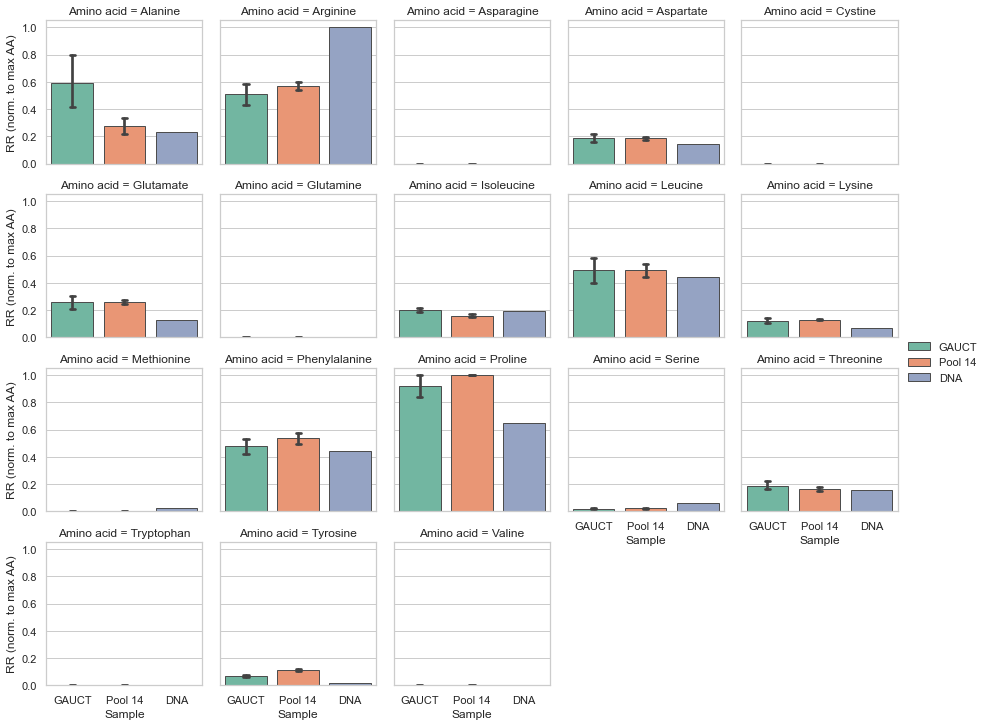

In [31]:
plot_name = 'GAUCT-Pool-14-DNA_HCl-amino-acid-release_comparison-bars.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Content', y='Peak area', ci=90, hue='Content', capsize=.1, dodge=False, palette='Set2', edgecolor='.3')
sns_fig.set_axis_labels('Sample', 'RR (norm. to max AA)')
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [32]:
df_metab_flat['new_key'] = df_metab_flat['Content'] + df_metab_flat['Amino acid']
aggregation_functions = {'Content': 'first', 'Amino acid': 'first', 'Peak area': 'mean'}
df_metab_flat_agg = df_metab_flat.groupby(df_metab_flat['new_key']).aggregate(aggregation_functions)

x = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'DNA']['Peak area'].values)*2
y1 = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'GAUCT']['Peak area'].values)
y2 = list(df_metab_flat_agg[df_metab_flat_agg['Content'] == 'Pool 14']['Peak area'].values)
names = ['GAUCT']*18 + ['Pool 14']*18

df_plot = pd.DataFrame(list(zip(names, x, y1+y2)), columns =['Pool', 'x', 'y'])

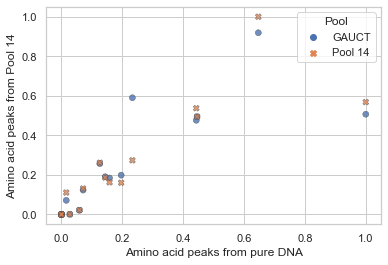

In [36]:
plot_name = 'GAUCT-Pool-14-DNA_HCl-amino-acid-release_comparison-scatter.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.scatterplot(x='x', y='y', data=df_plot, hue='Pool', alpha=0.8, markers=True, style='Pool', edgecolor='.3')
sns_fig.set(xlabel='Amino acid peaks from pure DNA', ylabel='Amino acid peaks from Pool 14')


pdf_plot.savefig(sns_fig.figure, bbox_inches='tight')
plt.show()
pdf_plot.close()

# Assessment of enzyme digestion of nucleotides

In [37]:
### Compare enzymatic digestion with different buffers ###
mask = (df['Exp. name'] == 'Enzyme/acid hydrolysis')
df_nuc = df[mask]

nucleoside_keys = pool14_keys + ['Inosine pos']
metab_mask = ['Buffer', 'Hydrolysis'] + nucleoside_keys + nucl_breakdown_keys
df_metab = df_nuc.loc[:, metab_mask]

metab_mask = ['Buffer', 'Hydrolysis']
for metab in nucleoside_keys + nucl_breakdown_keys:
    metab_name = metab[0:-4]
    if False:
        if metab in nucleoside_keys:
            metab_max = df_metab[df_metab['Hydrolysis'] == 'Enzyme'][metab].max()
        elif metab in nucl_breakdown_keys:
            metab_max = df_metab[df_metab['Hydrolysis'] == 'Acid'][metab].max()
        else:
            raise('hfgdsa')

    metab_max = df_metab[metab].max()
    df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

#for idx in df_metab.index.values:
#    mv = df_metab.loc[idx, metab_mask[1:]].values.max()
#    df_metab.loc[idx, metab_mask[1:]] = df_metab.loc[idx, metab_mask[1:]] / mv

df_metab_flat = pd.melt(df_metab, id_vars=['Buffer', 'Hydrolysis']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

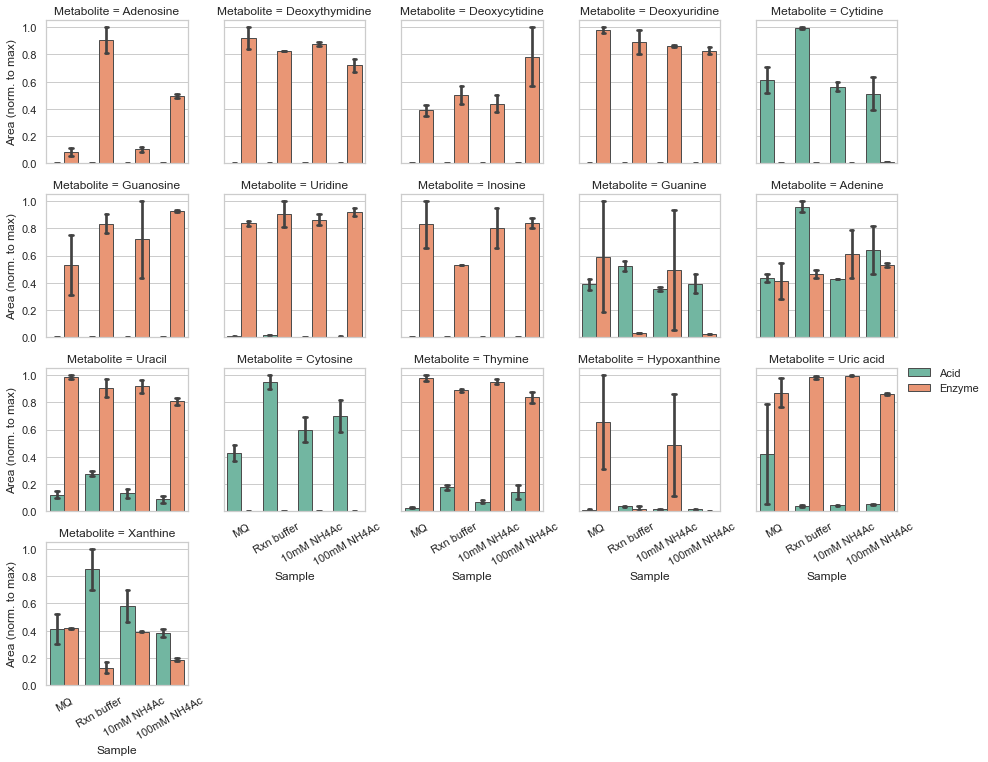

In [38]:
plot_name = 'enzyme-vs-acid-hydrolysis.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Metabolite', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Buffer', y='Peak area', ci=90, hue='Hydrolysis', capsize=.1, dodge=True, palette='Set2', edgecolor='.3')
sns_fig.set_axis_labels('Sample', 'Area (norm. to max)')
sns_fig.add_legend()
sns_fig.set_xticklabels(rotation=30)

pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [8]:
### Read measurements

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide-digest_acid-hydrolysis_09_18-dec_06-jan.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-15N' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned on
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and False:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2] + '_' + fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)


df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [9]:
### Show that large amounts of cell material can be hydrolysed without reaching 
### saturating concentrations of liberated metabolites ###
mask = df['Exp. name'] == 'Cell hydrolysis gradient'
df_cell = df[mask]



AA_short_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Lysine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Valine pos']
metab_keys = ['Cytidine pos', 'Uridine neg'] + GAUCT_keys + ['Xanthine neg'] + AA_short_keys



metab_mask = ['Amount'] + metab_keys
df_metab = df_cell.loc[:, metab_mask]

metab_mask = ['Amount']
metab_mask_AA = ['Amount']
metab_mask_base = ['Amount']
for metab in metab_keys:
    metab_name = metab[0:-4]
    if metab in AA_short_keys:
        metab_mask_AA.append(metab_name)
    elif metab in ['Cytidine pos', 'Uridine neg']+GAUCT_keys+['Xanthine neg']:
        metab_mask_base.append(metab_name)
    metab_max = df_metab[metab].max()
    if metab_max == 0:
        df_metab[metab_name] = df_metab[metab]
    else:
        df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Amount']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

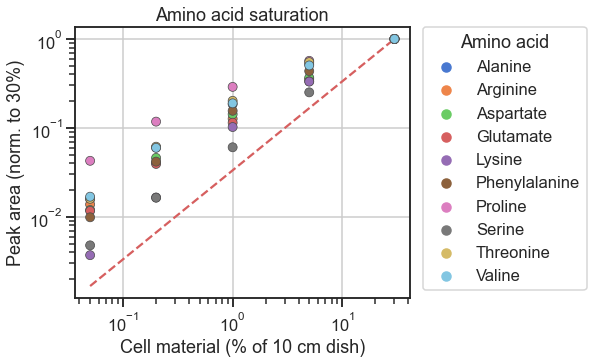

In [77]:
plot_name = 'whole-cell-AA-quant-saturation.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure(figsize=(6, 5))



mask = df_metab_flat['Metabolite'].isin(metab_mask_AA)
sns_fig = sns.scatterplot(data=df_metab_flat[mask], y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
sns_fig.set(xscale='log', yscale='log')


prop_x = np.linspace(0.05, 30, 1000)/30
prop_y = np.linspace(0.05, 30, 1000)
plt.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2)


plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Amino acid');
plt.grid(True)



plt.xlabel('Cell material (% of 10 cm dish)')#, size=12);
plt.ylabel('Peak area (norm. to 30%)')#, size=12);
plt.title('Amino acid saturation')#, size=14);


pdf_plot.savefig(fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

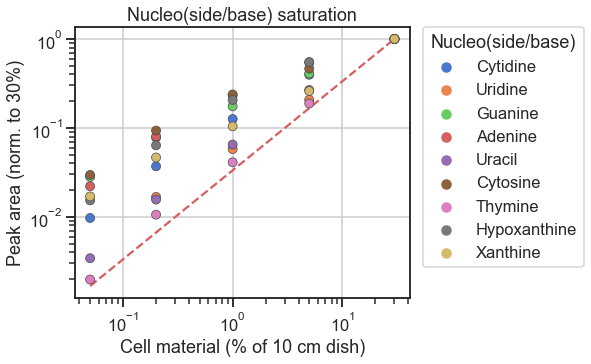

In [78]:
plot_name = 'whole-cell-nuc-quant-saturation.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure(figsize=(6, 5))



mask = df_metab_flat['Metabolite'].isin(metab_mask_base)
sns_fig = sns.scatterplot(data=df_metab_flat[mask], y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
sns_fig.set(xscale='log', yscale='log')


prop_x = np.linspace(0.05, 30, 1000)/30
prop_y = np.linspace(0.05, 30, 1000)
plt.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2)


plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Nucleo(side/base)');
plt.grid(True)



plt.xlabel('Cell material (% of 10 cm dish)')#, size=12);
plt.ylabel('Peak area (norm. to 30%)')#, size=12);
plt.title('Nucleo(side/base) saturation')#, size=14);


pdf_plot.savefig(fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [10]:
### Show linear range for amino acid quantification ###
mask = (df['Exp. name'] == 'Cell hydrolysis gradient') & (df['Amount'] != 30)
df_cell = df[mask]

metab_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Lysine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Valine pos']

metab_mask = ['Amount'] + metab_keys
df_metab = df_cell

metab_mask = ['Amount']
for metab in metab_keys:
    metab_name = metab[0:-4]

    df_metab[metab] = df_metab[metab] / df_metab['{}'.format(metab[0:-4] + ' U-13C' + metab[-4:len(metab)])]
    
    metab_max = df_metab[metab].max()
    if metab_max == 0:
        df_metab[metab_name] = df_metab[metab]
    else:
        df_metab[metab_name] = df_metab[metab] / metab_max
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Amount']).rename(columns={'variable': 'Metabolite', 'value': 'Peak area'})

<ipython-input-10-a1d4b1a031aa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab] = df_metab[metab] / df_metab['{}'.format(metab[0:-4] + ' U-13C' + metab[-4:len(metab)])]
<ipython-input-10-a1d4b1a031aa>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab_name] = df_metab[metab] / metab_max


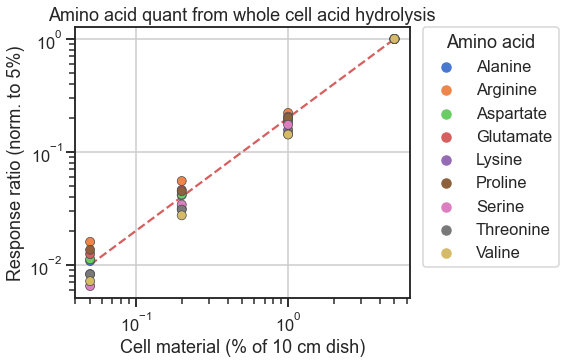

In [80]:
plot_name = 'whole-cell-AA-quant-linear-range.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure(figsize=(6, 5))

sns_fig = sns.scatterplot(data=df_metab_flat, y='Peak area', x='Amount', hue='Metabolite', edgecolor='.3', zorder=3)
sns_fig.set(xscale='log', yscale='log');

prop_x = np.linspace(0.05, 5, 1000)/5
prop_y = np.linspace(0.05, 5, 1000)
plt.plot(prop_y, prop_x, color='r', linestyle='dashed', zorder=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Amino acid');
plt.grid(True)

plt.xlabel('Cell material (% of 10 cm dish)')#, size=12);
plt.ylabel('Response ratio (norm. to 5%)')#, size=12);
plt.title('Amino acid quant from whole cell acid hydrolysis')#, size=14);


pdf_plot.savefig(fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [11]:
### Show whole cell acid hydrolysis is reproducible ###
mask = (df['Exp. name'] == 'DNA vs. cell acid hydrolysis') & (df['Content'] == 'Cells')
df_metab = df[mask]

AA_stable_keys = ['Alanine pos', 'Arginine pos', 'Aspartate neg', 'Glutamate neg', 'Glycine neg', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Tyrosine pos', 'Valine pos']

metab_keys = AA_stable_keys + GAUCT_keys + ['Xanthine neg']
metab_mask = list()
for metab in metab_keys:
    metab_name = metab[0:-4]
    
    #metab_mean = df_metab[metab].mean()
    metab_mean = df_metab[metab].values[0]
    if df_metab[metab].min() > 0:
        df_metab[metab_name] = 100 - (df_metab[metab] / metab_mean *100)
        metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab).rename(columns={'variable': 'Metabolite', 'value': 'Deviation'})

<ipython-input-11-00eaadd9c43f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metab[metab_name] = 100 - (df_metab[metab] / metab_mean *100)


0      True
1      True
2      True
3      True
4      True
      ...  
79    False
80     True
81     True
82     True
83     True
Name: Metabolite, Length: 84, dtype: bool

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


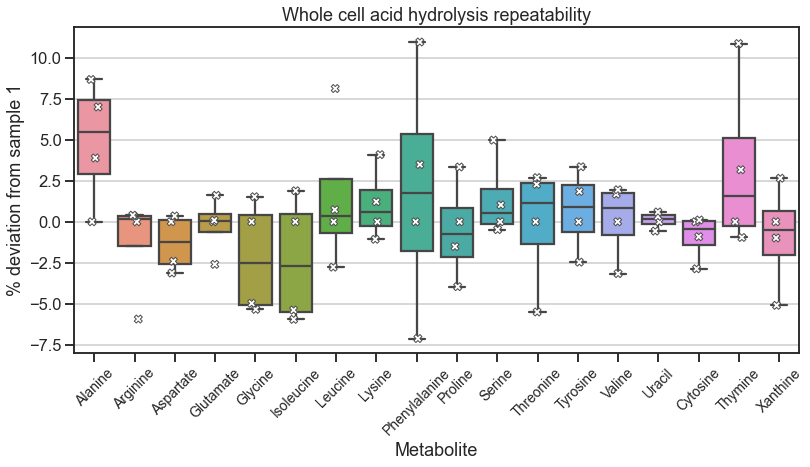

In [14]:
plot_name = 'whole-cell-metab-mes-repeatability.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure(figsize=(13, 6))

mask = (df_metab_flat['Metabolite'] != 'Hypoxanthine') & (df_metab_flat['Metabolite'] != 'Adenine') & (df_metab_flat['Metabolite'] != 'Guanine') 
sns_fig = sns.boxplot(data=df_metab_flat[mask], x='Metabolite', y='Deviation', fliersize=0)
sns.stripplot(data=df_metab_flat[mask], x='Metabolite', y='Deviation', jitter=True, split=True, linewidth=1, color='1', edgecolor='.3', marker='X', s=8)

plt.xticks(rotation=45, size=14);

plt.xlabel('Metabolite', size=18);
plt.ylabel('% deviation from sample 1', size=18);
plt.title('Whole cell acid hydrolysis repeatability', size=18);
plt.grid(True, axis='y')


pdf_plot.savefig(fig, bbox_inches='tight')
plt.show()
pdf_plot.close()